In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [2]:
env = UnityEnvironment(file_name="./Reacher_Windows_x86_64_1_agent/Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
pi = Variable(torch.FloatTensor([math.pi]), requires_grad=True).cuda()

def normal(x, mu, sigma_sq):
    a = (-1*(Variable(x, requires_grad=True)-mu).pow(2)/(2*sigma_sq)).exp()
    b = 1/(2*sigma_sq*pi.expand_as(sigma_sq)).sqrt()
    return a*b

def probs_to_actions(mu, sigma_sq):
    eps = torch.randn(mu.size())
    sigma_sq = torch.ones(mu.size()).cuda()
    action = (mu + sigma_sq.sqrt()*Variable(eps, requires_grad=True).cuda())
    prob = normal(action, mu, sigma_sq)
    
    return action.cpu().reshape(-1, 4), torch.log(prob).reshape(-1, 4)

class Policy(nn.Module):
    def __init__(self, state_size, action_size, fc1_size=256, fc2_size=128):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(33, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        
        self.fc3_mu = nn.Linear(fc2_size, action_size)
        self.fc3_sigma_squared = nn.Linear(fc2_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        mu = F.hardtanh(self.fc3_mu(x))
        sigma = F.relu(self.fc3_sigma_squared(x))
        
        return mu, sigma
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mu, sigma = self.forward(state)
        return probs_to_actions(mu, sigma)
        

In [7]:
def reinforce(n_episodes=300, max_t=300, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[brain_name].vector_observations
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            env_info = env.step(action.detach().cpu().numpy())[brain_name]
            state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
            rewards.append(reward)
            if np.any(done):
                break 
        
        mean_rewards = np.mean(np.sum(rewards, axis=0))
        scores_deque.append(mean_rewards)
        scores.append(mean_rewards)
        
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        R = np.sum(np.array([a*np.array(b) for a,b in zip(discounts, rewards)]), axis=0)
        
        if len(R) > 10:
            R_mean = np.mean(R)
            R_std = np.std(R)
            R = np.nan_to_num((R - R_mean) / R_std)
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * np.mean(R))

        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

In [8]:
policy = Policy(state_size=33, action_size=action_size).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

%time scores = reinforce()

Episode 100	Average Score: 0.11
Episode 200	Average Score: 0.19
Episode 300	Average Score: 0.28
Wall time: 12min 9s


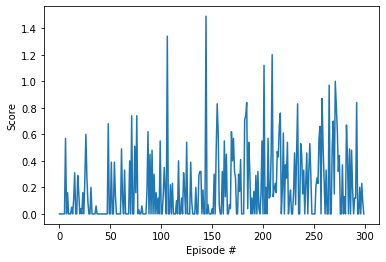

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()

ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "D:\Anaconda3\envs\gym\lib\multiprocessing\connection.py", line 312, in _recv_bytes
    nread, err = ov.GetOverlappedResult(True)
BrokenPipeError: [WinError 109] The pipe has been ended

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\envs\gym\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "D:\Anaconda3\envs\gym\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "D:\Anaconda3\envs\gym\lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "D:\Anaconda3\envs\gym\lib\multiprocessing\connection.py", line 321, in _recv_bytes
    raise EOFError
EOFError
